# Working with gravitational waves

Gravitational waves are one of the most important quantity in numerical-relativity simulations. Here, we will see how to extract the strain and how to do some of the most common operations with gravitational waves. For this, we will some some sample data that we will read with the  [SimDir](../simdir.rst) module.

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import numpy as np

from postcactus.simdir import SimDir

First, we load the data.

In [2]:
sim = SimDir("../../tests/gwsample")

Here, we are only interested in gravitational waves, to access those, we use the `.gws` or `.gravitational_waves` attributes.

In [3]:
gws = sim.gws

`gws` is a `GravitationalWavesDir` object: it contains all the available information about gravitational waves. To see it, you can print `gws`.

In [4]:
print(gws)

Avilable radii: [48.95, 60.13, 77.93, 53.96, 67.88, 91.46, 110.69, 44.78, 191.0, 140.16]

At radius 44.78, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 48.95, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 53.96, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 60.13, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 67.88, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 77.93, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 91.46, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 110.69, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 140.16, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])
At radius 191.0, (l, m) available: {(2, 2)} (missing: [(2, 0), (2, -2), (2, 1), (2, -1)])



We see the extraction radii available and the available multipoles. There's also information about the missing multipoles. This information is also avilable through the `available_lm` and `missing_lm` attributes in `gws`.
In this dataset we only have the (2, 2). In case you had a l=1 or l=0 mode, that would have been ignored.

Data from ASCII files or from hdf5 files is supported.

`gws` is like a dictionary, where the keys are the radii and the values are `GravitationalWaveOneDet`.

In [5]:
gws.keys()

[48.95, 60.13, 77.93, 53.96, 67.88, 91.46, 110.69, 44.78, 191.0, 140.16]

Let's focus on one extraction radius. You can access the corresponding `GravitationalWavesOneDet` with the bracket operator.

In [6]:
psi4 = gws[91.46]

`GravitationalWavesOneDet` contains $\Psi_4$ for the extraction radius selected. This object is very rich. You can see which multipoles are available with `available_l`, `available_m`, or `available_lm`. You can see the extraction radius with the `dist` method.

In [7]:
psi4.dist

91.46

You can loop over all the available (l, m) with a for loop. When you do this, you get the multipole l and m, and the corresponding timeseries. 

In [8]:
for l, m, ts in psi4:
    print(l, m, type(ts))

2 2 <class 'postcactus.timeseries.TimeSeries'>


`GravitationalWavesOneDet` are dictionary-like objects as well, with keys being the available (l, m). 

In [9]:
psi4_22 = psi4[(2, 2)]
# In case you forget the [], that would work too
psi4_22 = psi4(2, 2)
# Alternatively, you can use the get_psi4_lm method
psi4_22 = psi4.get_psi4_lm(2, 2)

This is a TimeSeries, we can plot it. $\Psi_4$ is a complex number, so we only plot the real part>

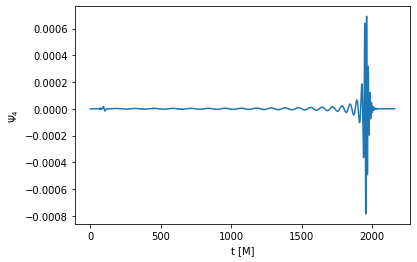

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("t [M]")
plt.ylabel("$\Psi_4$")
plt.plot(psi4_22.real())

In general, we are interested in the strain. `GravitationalWavesOneDet` objects have numerous methods to extract the strain. The most simple is the one to obtain the strain associated to a specific mode. This (as all the other methods that involve strains) needs to take a Fourier transform. To avoid aliasing effects, your signal should go smoothly to zero. In case it doesn't, you have to window it. To do this, you have to pass the `window_function` paramter, and all the additional paramters that the window may need. You can pass the window in multiple ways, but the simplest is to use one the window functions already coded up. In this example, we will use the Tukey window. If you don't need a window, you can pass `None` (or nothing).
In addition to the window, you have to provide `pcut`. This is the period that will go in the fixed-frequency integration (`omega_threshold = 2 * pi / pcut`). Choose pcut as the longest physical period you expect in your signal.

Also notice, when extracting the strain `h`, we always obtain `r * h`, where `r` is the extraction radius. 

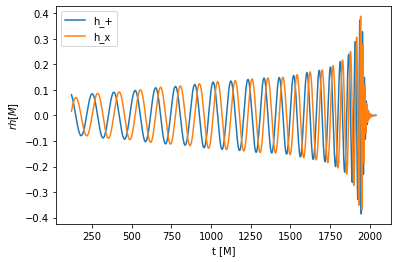

In [11]:
strain_22 = psi4.get_strain_lm(2, # l
                               2, # m
                               120, # pcut
                               0.1, # paramter of the window
                               window_function='tukey'
                               )
rhp = strain_22.real()
rhc = -strain_22.imag()

plt.xlabel("t [M]")
plt.ylabel("$rh [M]$")
plt.plot(rhp, label="h_+")
plt.plot(rhc, label="h_x")
plt.legend()

This is a beautiful gravitational-wave signal! If may not have noticed that the signal is a little bit shorter than $\Psi_4$. This is because, by default, we remove part of the signal at the beginning and at the end, which typically is not very accurate. If do not want this to happen, send `trim_ends` to `False`.

Now, let's consider the signal that would be observed by LIGO-Virgo interferometers with function `get_observed_strain`. This method takes into account all the available modes and the localization in the sky. It knows about LIGO Hanford, LIGO Livingston and Virgo and returns a `Detectors` object. We will see in a second how `Detectors` work. No noise is added or taken into account.

In [12]:
strains = psi4.get_observed_strain(8, # Right ascension
                                   -70, # Declination
                                    "2015-09-14 09:50:45", # Time UTC
                                   np.pi/3, # theta_gw
                                   0, # phi_gw
                                   120, # pcut
                                   0.1, # paramter of the window
                                   window_function='tukey'
                                   )

Now that we have `strains`, we can access its field as if they were attributes. The name of the fields are the different detectors.

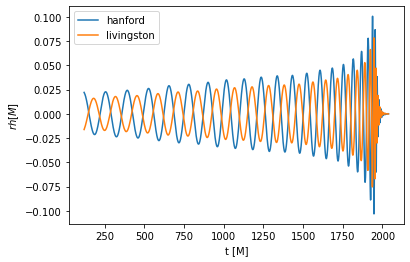

In [13]:
plt.xlabel("t [M]")
plt.ylabel("$rh [M]$")
plt.plot(strains.hanford, label="hanford")
plt.plot(strains.livingston, label="livingston")
plt.legend()

There are additional useful function in `gw_utils`, for example, if we want to compute the signal-to-noise ratio of GW150914 assuming design-sensitivity LIGO:

(Here we also see how to use bundled sensitivity curves)

In [14]:
# Let's convert this the strain to physical units
from postcactus import unitconv as uc
import postcactus.gw_utils as gwu

CU = uc.geom_umass_msun(65)
distance = 410  # Mpc
distance_SI = distance * uc.MEGAPARSEC_SI

strain_hanford = strains.hanford * CU.length / distance_SI
strain_hanford.time_unit_change(CU.time, inverse=True)
redshift = gwu.luminosity_distance_to_redshift(distance)
strain_hanford.redshift(redshift)

from postcactus.sensitivity_curves import Sn_aLIGO

freqs = np.linspace(20, 512, 1000)
aligo = Sn_aLIGO(freqs)

snr = gwu.signal_to_noise_ratio_from_strain(
    strain_hanford,
    0.1,
    noise=aligo,
    fmin=25,
    fmax=256,
    window_function="tukey",
)

print(f"SNR = {snr:.2f}")

SNR = 38.23


We can also compute energy and angular momentum carried away by these waves. There are methods to compute the instantaneous value, or the cumulative one. You can select a specific mode, or sum up all the modes.

Let's see a couple.

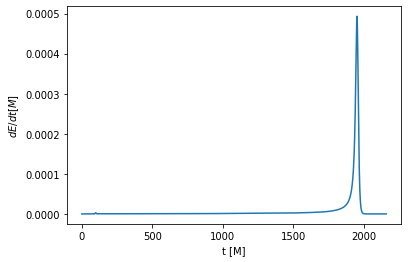

In [15]:
power_22 = psi4.get_power_lm(2, # l
                             2, # m
                             120 # pcut
                             )
plt.xlabel("t [M]")
plt.ylabel("$dE/dt [M]$")
plt.plot(power_22)

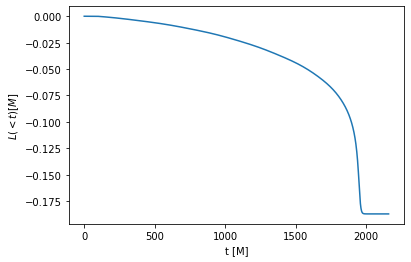

In [16]:
angmom = psi4.get_total_angular_momentum_z(120)

plt.xlabel("t [M]")
plt.ylabel("$L(<t) [M]$")
plt.plot(angmom)